In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = None
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

# k-Nearest Neighbor (kNN) exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

In this exercise you will implement these steps and understand the basic Image Classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code.

In [2]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


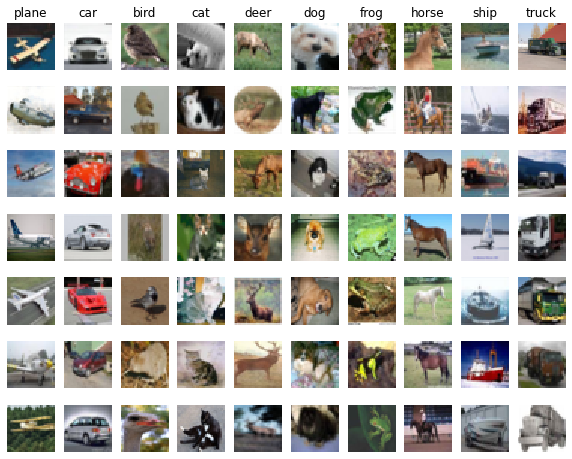

In [4]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [5]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [6]:
from cs231n.classifiers import KNearestNeighbor

# Create a kNN classifier instance. 
# Remember that training a kNN classifier is a noop: 
# the Classifier simply remembers the data and does no further processing 
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps: 

1. First we must compute the distances between all test examples and all train examples. 
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

**Note: For the three distance computations that we require you to implement in this notebook, you may not use the np.linalg.norm() function that numpy provides.**

First, open `cs231n/classifiers/k_nearest_neighbor.py` and implement the function `compute_distances_two_loops` that uses a (very inefficient) double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.

In [7]:
# Open cs231n/classifiers/k_nearest_neighbor.py and implement
# compute_distances_two_loops.

# Test your implementation:
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500, 5000)


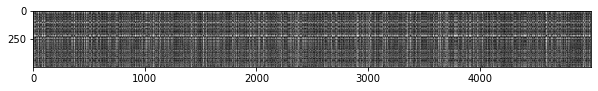

In [8]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists, interpolation='none')
plt.show()

**Inline Question 1** 

Notice the structured patterns in the distance matrix, where some rows or columns are visible brighter. (Note that with the default color scheme black indicates low distances while white indicates high distances.)

- What in the data is the cause behind the distinctly bright rows?
- What causes the columns?

$\color{blue}{\textit Your Answer:}$ *fill this in.*<br>
맨 처음 훈련 데이터의 크기는 (50000, 32, 32, 3)이고 각각의 요소는 50,000개의 데이터, 32x32 총 1,024 pixel의 RGB에 해당하는 값으로 추정<br>
그런데 X_train, X_test를 각각 5000개, 500개를 추출하였고, 테스트 데이터 1개와 훈련 데이터 1개를 추출해서 각각의 사진을 비교<br>
비교하는 방식은 매우 간단한데, 1개의 데이터에 해당하는 각각의 RGB값을 픽셀순서대로 한 줄로 쭉 늘여놓고<br>
한 번의 비교당 모든 픽셀의 L2-norm의 총 합을 구하는 것<br>
<br>
따라서 테스트 데이터 500개와 훈련 데이터 5000개를 비교를 해서 dists라는 행렬로 거리의 값을 저장을 시킨 것이므로<br>
500 x 5000의 크기의 행렬이 구해짐<br>
그런데 문제에서 낮은 거리 값은 어둡게 표현되고, 높은 거리 값은 밝게 표시된다고 언급<br>
<br>
따라서 밝게 표시된 부분은 L2-norm의 값이 크게 나온 부분으로 훈련 데이터와 테스트 데이터가 상당히 많은 차이를 보인다는 것을 알 수 있고<br>
다시 말해서 동일한 부류로 분류될 가능성이 낮다는 것을 의미

In [9]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


You should expect to see approximately `27%` accuracy. Now lets try out a larger `k`, say `k = 5`:

In [10]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 139 / 500 correct => accuracy: 0.278000


You should expect to see a slightly better performance than with `k = 1`.

**Inline Question 2**

We can also use other distance metrics such as L1 distance.
For pixel values $p_{ij}^{(k)}$ at location $(i,j)$ of some image $I_k$, 

the mean $\mu$ across all pixels over all images is $$\mu=\frac{1}{nhw}\sum_{k=1}^n\sum_{i=1}^{h}\sum_{j=1}^{w}p_{ij}^{(k)}$$
And the pixel-wise mean $\mu_{ij}$ across all images is 
$$\mu_{ij}=\frac{1}{n}\sum_{k=1}^np_{ij}^{(k)}.$$
The general standard deviation $\sigma$ and pixel-wise standard deviation $\sigma_{ij}$ is defined similarly.

Which of the following preprocessing steps will not change the performance of a Nearest Neighbor classifier that uses L1 distance? Select all that apply.
1. Subtracting the mean $\mu$ ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu$.)
2. Subtracting the per pixel mean $\mu_{ij}$  ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu_{ij}$.)
3. Subtracting the mean $\mu$ and dividing by the standard deviation $\sigma$.
4. Subtracting the pixel-wise mean $\mu_{ij}$ and dividing by the pixel-wise standard deviation $\sigma_{ij}$.
5. Rotating the coordinate axes of the data.

$\color{blue}{\textit Your Answer:}$
1, 2, 3만 L1-norm을 사용했을 때 분류기의 성능을 유지할 수 있음

$\color{blue}{\textit Your Explanation:}$<br>
우선 L1-norm이 어떻게 구해지는지 살펴보면<br>
i번째 이미지와 j번째 이미지의 모든 픽셀에서의 L1-norm의 합은<br>
$D_{ij} = \displaystyle\sum \left(\left\vert R_i-R_j \right\vert + \left\vert G_i - G_j \right\vert + \left\vert B_i - B_j \right\vert \right)$로 구할 수 있음<br>
<br>
픽셀들의 값을 다음과 같이 전처리를 한다고 가정할 때<br>
1. $\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu$<br>
  이 경우 모든 픽셀에 있는 값의 평균을 모든 픽셀에 대해 빼주는 경우<br>
  모든 픽셀들의 값이 일정한 값($\mu$)만큼 값이 떨어지게되므로 분류기 성능에 영향이 없음<br>
  <br>
  임의의 i번째 테스트 이미지와 j번째 테스트 이미지의 L1-norm을 구할 때 모든 픽셀에 대해서 다음과 같이 L1_norm을 구할 수 있음<br>
  $ \left\vert (R_i - \mu) - (R_j - \mu) \right\vert + \left\vert (G_i - \mu) - (G_j - \mu) \right\vert + \left\vert (B_i - \mu) - (B_j - \mu) \right\vert = \left\vert R_i-R_j \right\vert + \left\vert G_i - G_j \right\vert + \left\vert B_i - B_j \right\vert$<br>
<br>
2. $\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu_{ij}$<br>
  이 경우 이미지들의 픽셀별로 평균을 구하고 픽셀별로 각각의 픽셀 값을 빼주는 경우<br>
  L1-norm은 같은 픽셀 값들끼리 계산을 하고 같은 픽셀들끼리는 같은 평균값을 적용받으므로 마찬가지로 분류기 성능에는 영향이 없음<br>
  <br>
  임의의 i번째 테스트 이미지와 j번째 테스트 이미지의 L1-norm을 구할 때 모든 픽셀에 대해서 다음과 같이 L1_norm을 구할 수 있음<br>
  $ \left\vert (R_i - \mu_{ij}) - (R_j - \mu_{ij}) \right\vert + \left\vert (G_i - \mu_{ij}) - (G_j - \mu_{ij}) \right\vert + \left\vert (B_i - \mu_{ij}) - (B_j - \mu_{ij}) \right\vert = \left\vert R_i-R_j \right\vert + \left\vert G_i - G_j \right\vert + \left\vert B_i - B_j \right\vert$<br>
<br>

3. $\tilde{p}_{ij}^{(k)}=\frac{p_{ij}^{(k)}-\mu}{\sigma}$<br>
  이 경우는 1.에서 모든 픽셀들에 대해 연산된 표준편차$\sigma$를 나눠주는 경우<br>
  모든 픽셀들의 값이 일정한 값($\mu$)만큼 값이 떨어지게되고 일정한 표준편차($\sigma$)만큼 나누어지게된 것이므로 분류기의 성능에는 영향이 없음<br>
  다만 1.과 비교했을 때 모든 픽셀들의 값을 일정한 표준편차로 나누어주었기 때문에 스케일의 차이는 있음<br>
  <br>
  만약 $d_{ij} > d_{ik}$에 대해서 생각해보면($\sigma > 0$)<br>
  $\tilde{d_{ij}} = \frac{1}{\sigma}d_{ij}, \quad \tilde{d_{ik}} = \frac{1}{\sigma}d_{ik} \rightarrow \frac{1}{\sigma}d_{ij} > \frac{1}{\sigma}d_{ik} \Leftrightarrow \tilde{d_{ij}} > \tilde{d_{ik}}$<br>
  <br>
  따라서 모든 픽셀에 대해서 $\tilde{d_{ij}} > \tilde{d_{ik}}$임을 알 수 있음<br>
<br>
4. $\tilde{p}_{ij}^{(k)}=\frac{p_{ij}^{(k)}-\mu_{ij}}{\sigma_{ij}}$<br>
  이 경우는 2.에서 각 픽셀들끼리 대해 연산된 해당 픽셀의 표준편차$\sigma_{ij}$를 나눠주는 경우<br>
  어떤 두 픽셀에서 L1-norm의 값이 같았다고 가정<br>
  $ d_{ij} = d_{ik} = d_1$일 때<br>
  $ \tilde{d_{ij}} = \frac{1}{\sigma_{ij}}d_1 = d_2$<br>
  $ \tilde{d_{ik}} = \frac{1}{\sigma_{ik}}d_1 = d_3$<br>
  <br>
  이 때, $d_2 = d_3$라면 $\sigma_{ij} = \sigma_{ik}$가 성립해야 하나<br>
  실제로 각각의 픽셀들에 대해서 살펴보면 이미지들의 같은 픽셀들 값의 표준편차는 픽셀들마다 얼마든지 다를 수 있음<br>
  따라서 $\sigma_{ij} \ne \sigma_{ik}$인 경우에 $d_2 \ne d_3$이므로 분류기의 성능에는 영향이 있음<br>
<br>
5. 축을 따라서 회전<br>
  직관적으로 분류기의 성능에 영향이 있음을 알 수 있는데 임의의 두 점에 대해서 생각을 해보면<br>
  $(1, 0)$과 $(0, 1)$의 L1-norm은 2이지만, 두 점을 반시계방향으로 45도 만큼 회전시키면<br>
  두 점의 L1_norm은 $\sqrt{2}$임을 알 수 있음<br>
  따라서 기존의 각각의 L1-norm의 대소관계가 보존되지않기 때문에 분류기의 성능에는 영향이 있음<br>
  <br>
  $ x' = Ax$으로 각각의 점을 회전시키고 L1-norm을 구할 수 있음
  $\left( A = \begin{bmatrix} cos\theta&-sin\theta \\ sin\theta&cos\theta \end{bmatrix} \right)$

In [14]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:
dists_one = classifier.compute_distances_one_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(dists - dists_one, ord='fro')
print('One loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

One loop difference was: 0.000000
Good! The distance matrices are the same


In [15]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_two = classifier.compute_distances_no_loops(X_test)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('No loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

No loop difference was: 0.000000
Good! The distance matrices are the same


In [16]:
# Let's compare how fast the implementations are
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

# You should see significantly faster performance with the fully vectorized implementation!

# NOTE: depending on what machine you're using, 
# you might not see a speedup when you go from two loops to one loop, 
# and might even see a slow-down.

Two loop version took 29.786332 seconds
One loop version took 8.565629 seconds
No loop version took 0.155334 seconds


### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [45]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
X_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}


################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# 가능한 k값에 대해 시행
for k in k_choices:
    # 총 num_folds만큼 시행
    for i in range(num_folds):
        # 훈련 데이터와 검증 데이터 분류
        # X_train은 5000개의 데이터에 3072개 요소가 있고 3072개의 요소는 하나의 값과 대응되어야 하므로 vstack
        X_train_data = np.vstack(X_train_folds[:i] + X_train_folds[i+1:])
        # y_train은 5000개의 데이터에 label값 1개씩 있으므로 1차원으로 쭉 나열하듯이 값을 배치해야 X_train의 예측값과 대응 
        y_train_data = np.hstack(y_train_folds[:i] + y_train_folds[i+1:])
        X_val_data, y_val_data = X_train_folds[i], y_train_folds[i]
        

        # 훈련을 시행
        classifier.train(X_train_data, y_train_data)

        # 거리 구하기
        # 검증 데이터와 훈련 데이터의 L2-norm 구하기
        dists = classifier.compute_distances_no_loops(X_val_data)

        # 검증 데이터에 대해 예측
        y_pred = classifier.predict_labels(dists, k=1)

        # 정확도 계산
        num_correct = np.sum(y_pred == y_val_data)
        accuracy = float(num_correct) / len(y_val_data)
        
        # 1회 시행 후 정확도를 기록(총 num_folds만큼 시행)
        # k: [. . . . .] 형태로 기록
        k_to_accuracies[k] = k_to_accuracies.get(k, []) + [accuracy]

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

k = 1, accuracy = 0.263000
k = 1, accuracy = 0.257000
k = 1, accuracy = 0.264000
k = 1, accuracy = 0.278000
k = 1, accuracy = 0.266000
k = 3, accuracy = 0.263000
k = 3, accuracy = 0.257000
k = 3, accuracy = 0.264000
k = 3, accuracy = 0.278000
k = 3, accuracy = 0.266000
k = 5, accuracy = 0.263000
k = 5, accuracy = 0.257000
k = 5, accuracy = 0.264000
k = 5, accuracy = 0.278000
k = 5, accuracy = 0.266000
k = 8, accuracy = 0.263000
k = 8, accuracy = 0.257000
k = 8, accuracy = 0.264000
k = 8, accuracy = 0.278000
k = 8, accuracy = 0.266000
k = 10, accuracy = 0.263000
k = 10, accuracy = 0.257000
k = 10, accuracy = 0.264000
k = 10, accuracy = 0.278000
k = 10, accuracy = 0.266000
k = 12, accuracy = 0.263000
k = 12, accuracy = 0.257000
k = 12, accuracy = 0.264000
k = 12, accuracy = 0.278000
k = 12, accuracy = 0.266000
k = 15, accuracy = 0.263000
k = 15, accuracy = 0.257000
k = 15, accuracy = 0.264000
k = 15, accuracy = 0.278000
k = 15, accuracy = 0.266000
k = 20, accuracy = 0.263000
k = 20, accu

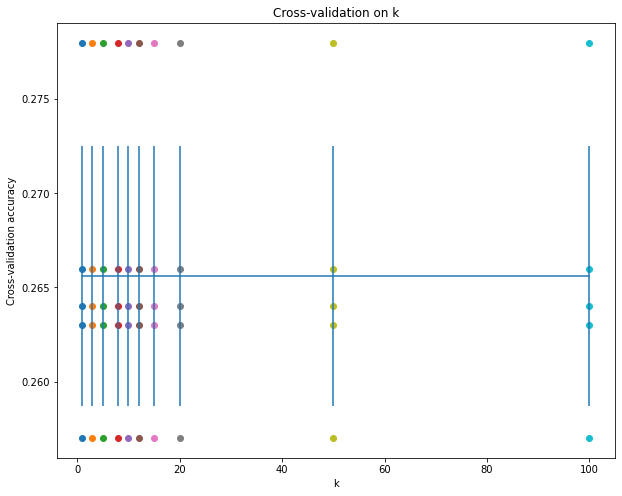

In [46]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [47]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = 1

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


**Inline Question 3**

Which of the following statements about $k$-Nearest Neighbor ($k$-NN) are true in a classification setting, and for all $k$? Select all that apply.
1. The decision boundary of the k-NN classifier is linear.
2. The training error of a 1-NN will always be lower than or equal to that of 5-NN.
3. The test error of a 1-NN will always be lower than that of a 5-NN.
4. The time needed to classify a test example with the k-NN classifier grows with the size of the training set.
5. None of the above.

$\color{blue}{\textit Your Answer:}$


$\color{blue}{\textit Your Explanation:}$
1. 거짓<br>
데이터가 산발적으로 흩어졌을 때 결정 경계가 선형으로 나타내질 수 있을 것 같아보여도<br>
하나의 클래스에 해당하는 데이터들이 어떤 비선형의 곡선으로 이어진 형태라면<br>
결정 경계는 비선형일 수 있음<br>
<br>
예를 들어 원점$(0,0)$에서 데이터의 클래스가 A이고 A를 중심으로 거리가 1인 자취에 해당하는 모든 데이터가 이어져 있고<br>
그 데이터들의 클래스가 B라면 결정 경계는 원점을 중심으로 떨어진 거리가 0.5인 즉 반지름이 0.5인 원으로 결정 경계가 그려지므로<br>
주어진 명제는 거짓임을 알 수 있음<br>
<br>
2. 참 / 3. 거짓<br>
테스트 데이터로 테스트를 진행할 때 그 중에서도 1-NN일 때에는 무조건 정확도는 100%<br>
그 이유는 훈련된 데이터가 테스트 데이터와 완벽히 동일하기 때문<br>
그러나 현재 데이터(클래스 A) 주변으로 4개의 데이터(클래스 B)가 있다면 5-NN일 경우에 잘못 예측을 하게 됨<br>
따라서 현재 제일 가까운 데이터(자기자신)와 다른 클래스의 4개가 주변에 있다면 잘못 예측할 수 있는 경우가 생기게 되므로<br>
훈련 데이터를 이용하여 테스트를 진행할 때에는 1-NN의 경우가 가장 정확도가 높다고 볼 수 있음<br>
<br>
그러나 새로운 데이터를 가지고 테스트를 하게되면 테스트 데이터 주변 훈련 데이터의 기록에 의존하게 되고<br>
각각의 훈련 데이터에 대응되는 값은 얼마인지 모르기 때문에 1-NN과 5-NN의 결과값은 알 수 없음<br>
<br>

4. 참<br>
우선 테스트 데이터를 분류를 하는 과정을 살펴보면<br>
하나의 테스트 데이터를 기준으로 T개의 훈련 데이터와의 L2-norm을 구하고<br>
구한 L2-norm의 값들을 가장 작은 값 순서대로 K개를 구하기위해 정렬시킴<br>
이 때 훈련데이터의 크기가 커지면 커질수록 당연히 테스트 데이터를 분류하는데 필요한 시간 또한 늘어날 수 밖에 없음<br> 